## Part 1 ‐ Exploratory data analysis

#### Aggregation of logins counts based on 15 minute time intervals, and visualization of  the resulting time series of login counts in ways that best characterize the underlying patterns of the demand.

In [1]:
import pandas as pd
import numpy as np
import os
import json
import statsmodels as sm
from statsmodels.tsa import seasonal
import matplotlib.pyplot as plt
import seaborn as sns

#### Load the data

In [2]:
# Read in the data
logins = pd.read_json('logins.json')
logins_df = pd.DataFrame(logins)

In [3]:
logins_df.shape

(93142, 1)

In [4]:
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


There are no null values

In [5]:
# index on the time column
logins_df.set_index('login_time',inplace=True)

# Add a numeric column to store counts
logins_df['counts'] = 1


In [6]:
# Resample the data
rdf = logins_df.resample('15T').sum()
rdf

,counts
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


In [7]:
rdf.shape

(9788, 1)

In [8]:
rdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   counts  9788 non-null   int64
dtypes: int64(1)
memory usage: 152.9 KB


Now we can begin our analysis. The statsmodels library provides an implementation of the naive, or classical, decomposition method in a function called seasonal_decompose(). We will observe the seasonal decomposition of the data over time to look for trends and patterns.

The result object provides access to the trend and seasonal series as arrays. It also provides access to the residuals, which are the time series after the trend, and seasonal components are removed. Finally, the original or observed data is also stored.

In [9]:
r = sm.tsa.seasonal.seasonal_decompose(rdf.counts,model='additive',period=100)

Text(0.5, 1.0, 'total logins residuals')

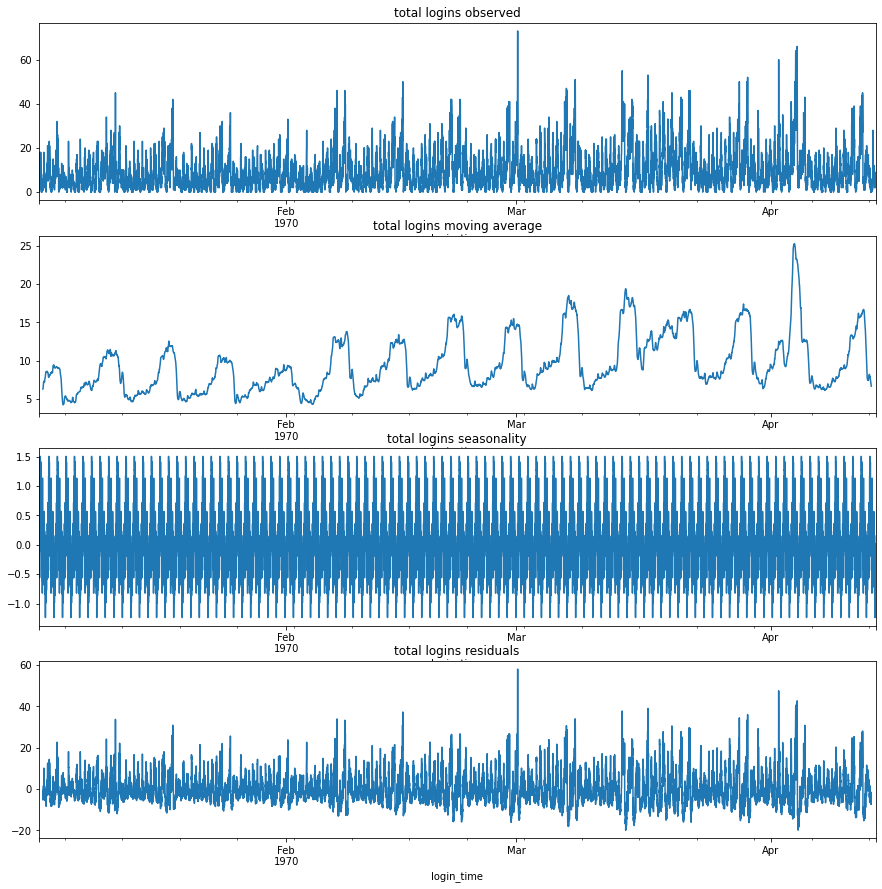

In [10]:
plt.figure(figsize=(15,15))
plt.subplot(4,1,1)
r.observed.plot()
plt.title('total logins observed')
plt.subplot(4,1,2)
r.trend.plot()
plt.title('total logins moving average')
plt.subplot(4,1,3)
r.seasonal.plot()
plt.title('total logins seasonality')
plt.subplot(4,1,4)
r.resid.plot()
plt.title('total logins residuals')

We can see that the entire series was taken as the trend component and that there was no seasonality.
There is a pattern to the logins over time, but the data as displayed here is hardly interpretable. 
It is apparent that there is a weekly upward trend to the login patterns over time. 

To get a closer look, check the daily and weekly patterns of logins by taking the mean across each over time.

In [11]:
daily = rdf.counts.groupby(rdf.index.hour).mean()

In [12]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
weekly = rdf.counts.groupby(rdf.index.day_name()).mean().reindex(days)


Text(0.5, 1.0, 'average logins by day of week')

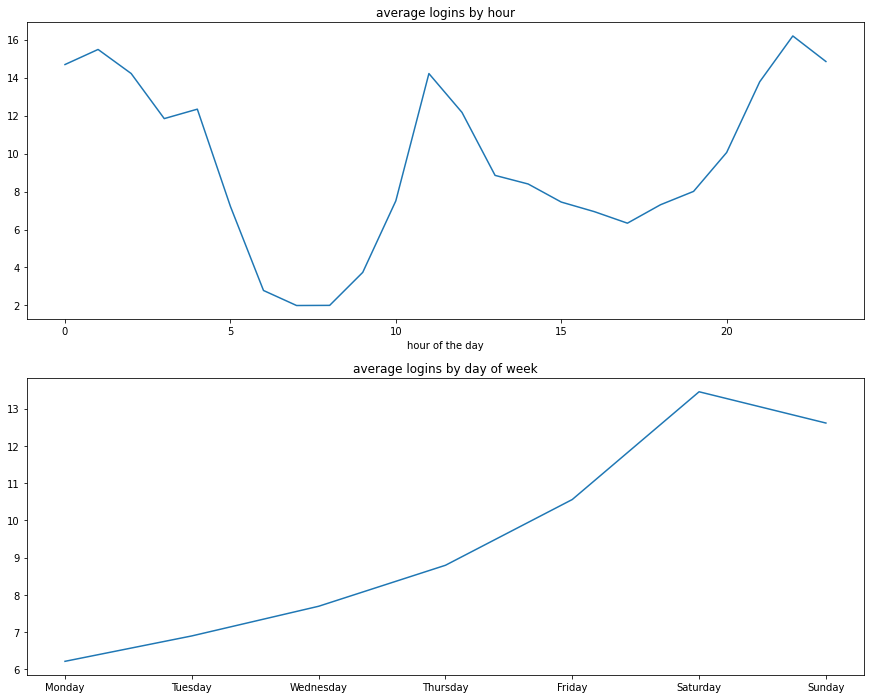

In [13]:
#plot daily and weekly average logins
plt.figure(figsize=(15,12))
plt.subplot(2,1,1)
plt.plot(daily)
plt.title('average logins by hour')
plt.xlabel('hour of the day')
plt.subplot(2,1,2)
plt.plot(weekly)
plt.title('average logins by day of week')

It is clear that the login activity reaches its pek at midnight and gradually comes down till 6:00 AM in the morning and then again it raises reaching a peak at 12:00 noon.

Also, the daily logins are at its lowest on Monday and gradually increases throughout the week reaching its peak on Saturday with a slight dip on Sunday. It again starts at its lowest point on Monday.

## Part 2 ‐ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
* a. how you will implement the experiment
* b. what statistical test(s) you will conduct to verify the significance of the
observation
* c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

### Part 2 - Answers

**What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?**

I will use the gross revenue of the transportation companies as the key to measure success for this experiment. Reimbursing all toll costs alone will not incentivize the transportation companies to encourage driver partners to be available in both cities, unless there is increased revenue. 


**Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:**

**a. How you will implement the experiment?**

Measure the gross revenue of the transportation companies for both cities before and after implementing reimbursement of toll costs

**b. what statistical test(s) you will conduct to verify the significance of the observation?**

To test the effectiveness of proposed change in toll fee, I will use t-test for paired observations. We measure one group at two different times, here the same taxi/transportation company will be compared before and after eliminating toll free.

**c. How you would interpret the results and provide recommendations to the city operations team along with any caveats.**

**H<sub>null</sub>**:The null hypothesis is that the gross revenue of the transportation companies for Gotham city will remain same even if the toll fee is eliminated.

**H<sub>alternative</sub>**:The alternate hypothesis is the gross revenue of the transportation companies for Gotham city will increase if the the toll fee is eliminated.
Alternately:
**H<sub>null</sub>**:The null hypothesis is that the gross revenue of the transportation companies for Metropolis city will remain same even if the toll fee is eliminated.

**H<sub>alternative</sub>**:The alternate hypothesis is the gross revenue of the transportation companies for Metropolis city will increase if the the toll fee is eliminated.

We will construe the results based on t-statistic if it is significant at 95% confidence interval.
If the null hypothesis is rejected then there is an evidence to support that free toll fee is beneficial to one or both cities. 

The limitations/assumptions are:
* The experiment is conducted in such a way that there is no impact of seasonality or peak season. 
* The traffic conditions for both cities before and after the experiment are the same.

## Part 3 - Predictive modeling

In [14]:
# Read in the data
data = pd.read_json('ultimate_data_challenge.json')
df = pd.DataFrame(data)

In [15]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [16]:
df.shape

(50000, 12)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [18]:
# the phone column has some missing values. Let's investigate further
df.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [19]:
# the missing vales may be because they were not iphone or Android. Lets fill these with the value others.
df.phone.fillna('others',inplace=True)

We do have some missing values for avg_rating_of_driver and avg_rating_by_driver. We will address this by filling the missing values with mean.

In [20]:
df.avg_rating_of_driver.fillna(df.avg_rating_of_driver.mean(),inplace=True)
df.avg_rating_by_driver.fillna(df.avg_rating_by_driver.mean(),inplace=True)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    50000 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   50000 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    50000 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [22]:
#Let's convert the dates to right format
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.signup_date = pd.to_datetime(df.signup_date)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

#### Percentage of user retention

In [24]:
max_last_trip_date = df.last_trip_date.max()
max_last_trip_date

Timestamp('2014-07-01 00:00:00')

The last trip date in the dataset is 7/1/2014, it looks like the data was pulled on July 1st, 2014. 

By definition, retained users made a trip within the last 30 days of this date. Let's see how many users have been retained:

In [25]:
df['retained'] = 0
df.loc[df.last_trip_date >= '2014-06-01', 'retained'] = 1
df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.700000,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.000000,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.300000,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.600000,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.400000,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.000000,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2,1
49996,Astapor,1,2014-01-24,4.601559,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0,0
49997,Winterfell,0,2014-01-31,5.000000,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0,0
49998,Astapor,2,2014-01-14,3.000000,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5,0


In [26]:
user_retention = round(df.retained.sum()/df.shape[0]*100,2)
print('Percentage of users considered retained are:'+ str(user_retention) +'%')

Percentage of users considered retained are:37.61%


### Exploratory Data Analysis

Let's do some basic EDA showing relationships between our features and our new, created target variable.

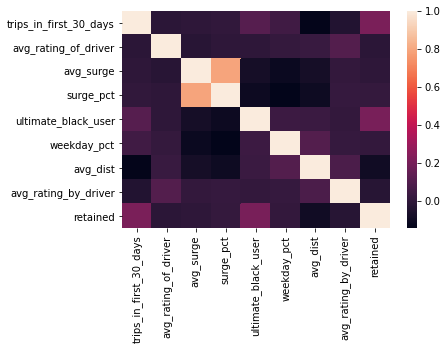

In [27]:
fig = plt.figure()
ax = plt.subplot(111)
corr = df.corr()
ax = sns.heatmap(corr)
plt.show()

In [28]:
corr.retained.sort_values(ascending=False)

retained                  1.000000
trips_in_first_30_days    0.210463
ultimate_black_user       0.205002
surge_pct                 0.011797
weekday_pct               0.009693
avg_surge                -0.003333
avg_rating_of_driver     -0.010829
avg_rating_by_driver     -0.026748
avg_dist                 -0.092780
Name: retained, dtype: float64

Whether a user was retained or not is somewhat correlated with the number of trips in the user's first 30 days and whether they are an Ultimate Black user or not. There isn't much correlation or anti-correlation with anything else.

Let's see the relationship between retained and our non-numeric columns: city, phone. Before that we will onehot encode them.

In [29]:
df = pd.get_dummies(df, columns = ['city', 'phone', 'ultimate_black_user'], drop_first=True)

In [30]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_King's Landing,city_Winterfell,phone_iPhone,phone_others,ultimate_black_user_True
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158,0.376080,0.202600,0.466720,0.691640,0.007920,0.37708
std,3.792684,0.564977,0.222336,19.958811,37.081503,5.707357,0.445753,0.484405,0.401941,0.498896,0.461821,0.088642,0.48466
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,4.500000,1.000000,0.000000,33.300000,2.420000,4.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,1.000000,4.700000,1.000000,0.000000,66.700000,3.880000,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.00000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


We can see that 46% are from Winterfell,20% from King's landing and remanining 33% from Astapor.
Iphone is the maximum used with around 70% using it.

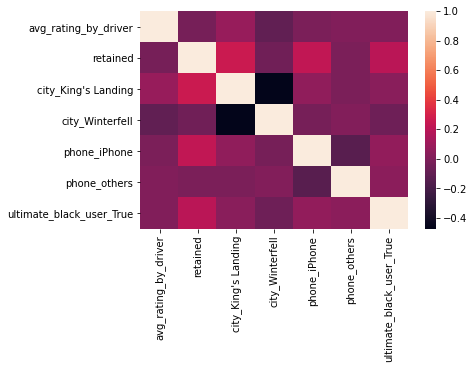

In [31]:
categoricals = df.iloc[:,-7:]
fig = plt.figure()
ax = plt.subplot(111)
corr = categoricals.corr()
ax = sns.heatmap(corr)
plt.show()

In [32]:
corr['retained'].sort_values(ascending=False)

retained                    1.000000
city_King's Landing         0.262284
phone_iPhone                0.225244
ultimate_black_user_True    0.205002
phone_others               -0.007419
avg_rating_by_driver       -0.026748
city_Winterfell            -0.046611
Name: retained, dtype: float64

We see that being from King's Landing and using an iPhone and ultimate_black_user are associated with being retained. Being from Astapor or Winterfell or using an Android are negatively associated with retention.


In [33]:
# Drop datetime features
df.drop(['signup_date', 'last_trip_date'], axis=1, inplace=True)

We have looked at the relationship between the features and also created a target column 'retained'. To handle the 'city' and 'phone' categorical columns we used one-hot-encode these features first.

Also, all of our features are numeric now, so we are ready for modelling.

### Model

Churn prediction is typically treated it as a classification problem, classifying a customer as yes/no for churning.

Logistic regression is an algorithm used for binary classification problems. It predicts the likelihood of an event by measuring the relationship between a dependent variable and one or more independent variables (features). More specifically, logistic regression will predict the possibility of an instance (data point) belonging to the default category.

Logistic Regression is an easy starting point.  It’s easy to explain and implement.


**Split data into training and test sets**

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
X = df.drop('retained',axis=1)
y = df.retained

X_scaled = StandardScaler().fit_transform(X)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40000, 12)
(10000, 12)
(40000,)
(10000,)


In [36]:
#logreg = LogisticRegression()
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

LogisticRegression()

In [37]:
#create the predictions on the test data
y_pred = logreg.predict(X_test)

In [38]:

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[5250  969]
 [1880 1901]]
              precision    recall  f1-score   support

           0       0.74      0.84      0.79      6219
           1       0.66      0.50      0.57      3781

    accuracy                           0.72     10000
   macro avg       0.70      0.67      0.68     10000
weighted avg       0.71      0.72      0.71     10000



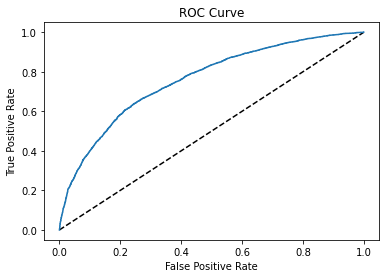

AUC: 0.7595834769177682


In [39]:
y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

In [40]:
cv_auc = cross_val_score(logreg,X_scaled,y,cv=5,scoring='roc_auc')
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC scores computed using 5-fold cross-validation: [0.76422994 0.75707071 0.75216778 0.76069058 0.76830335]


In [41]:
log_loss(y_test,y_pred_prob)

0.5596498798459772

In [42]:
#model coefficients
Coefficients = pd.DataFrame()
Coefficients['features'] = X.columns
Coefficients['model_coefficients'] = np.transpose(logreg.coef_)
Coefficients

,features,model_coefficients
0,trips_in_first_30_days,0.461301
1,avg_rating_of_driver,-0.030937
2,avg_surge,-0.043250
3,surge_pct,0.091467
4,weekday_pct,-0.003821
5,avg_dist,-0.208550
6,avg_rating_by_driver,-0.068640
7,city_King's Landing,0.691343
8,city_Winterfell,0.263895
9,phone_iPhone,0.501424


<AxesSubplot:>

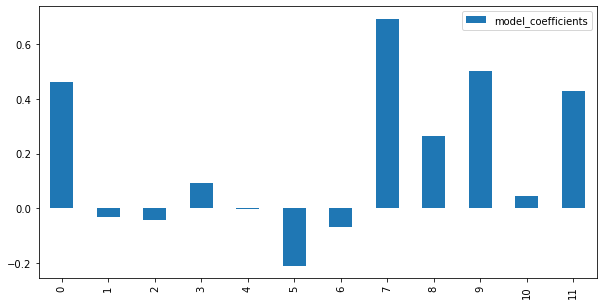

In [43]:
Coefficients.plot(kind='bar',figsize=(10,5))

I used logistic regression because it a robust and proven method for modeling customer churn. It also has the benefit of being pretty clear about each feature factors into the model which can be useful for analysis. This model gives a ROC AUC of below 0.8 so it is not exceptionally accurate but the value has been cross validated and should provide a fairly robust baseline prediction.


Looking at the model coefficients, we can see that the 3 biggest postive predictors of customer retention are:
* Being in the city of King's Landing 
* The number of trips the user took in the first 30 days
* Being an iphone user
* Having used Ultimate black. 

The 3 biggest predictors of customer churn are:
* The average distance per trip taken in the first 30 days after signup
* Not having been rated by a driver
* The average surge multiplier over all of this user’s trips
* Not having given the driver a rating

Few suggestions are:
* The company should try to get more customers to try Ultimate black they may see an increase in retention. 
* Advertise more towards Android users to encourage more customers to use the service. 
* Give more incentives to the users in the first 30 days as we can see the more rides the user takes, it is more likely we will retain them.
* Monitor customer ratings and give incentives to drivers with consistent high ratings
* Majority of users are from King's Landing. Advertise more in other cities to create awareness.


### Conclusion

We built a pretty strong model for our first go around. Building any machine learning model is an iterative process, and classification modeling itself has several types of models. We can explore other methods, such as Random Forest, Support Vector Modeling, and XGboost, to see if we can improve on this customer churn model.